# Extended Forecasting Tutorial 

In the extended forecasting tutorial we cover the following topics.

---
> ## Table of contents
> 1. ### <span style="color:orange">Datasets</span>
    1.1 Conjuntos de datos disponibles en GluonTS
    1.2 Crea conjuntos de datos artificiales con GluonTS
    1.3 Utilice sus series de tiempo y características
> 2. ### <span style="color:orange">Transformación</span>
    2.1 Definir transformaciones  
    2.2 Transformar un conjunto de datos
> 3. ### <span style="color:orange">Entrenar modelo existente</span>
    3.1 Configurar un estimador  
    3.2 Cargar el predictor  
    3.3 Guardado/cargado de modelo  
> 4. ### <span style="color:orange">Evaluación</span>
    4.1 Estimar la proyección  
    4.2 Calcular métricas  
> 5. ### <span style="color:orange">Crear un modelo proio</span>
    5.1 Proyecciones sin rangos usando redes neuronales  
    5.2 Proyecciones probabilisitcas  
    5.3 Añadir y escalar variables   
    5.4 De una red tradicional a un RNN
    
---

In [1]:
# Instalado de paquetes
!pip install mxnet
!pip install gluonts

     |████████████████████████████████| 46.9MB 90kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 573kB 27.2MB/s 
     |████████████████████████████████| 194kB 43.7MB/s 
     |████████████████████████████████| 8.6MB 38.7MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp37-cp37m-linux_x86_64.whl size=68371 sha256=2f3d6656795b28fe9c51577856280623ec1e7407671be9b12914654814f68eb1
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson


In [2]:
# Importación de paquetes
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

In [3]:
mx.random.seed(0)
np.random.seed(0)

# 1. Datasets

El primer requisito para utilizar GluonTS es tener un conjunto de datos adecuado. GluonTS ofrece tres opciones diferentes a los profesionales que desean experimentar con los distintos módulos:

- Utilice un conjunto de datos disponible proporcionado por GluonTS
- Crea un conjunto de datos artificial usando GluonTS
- Convierta su conjunto de datos a un formato compatible con GluonTS

En general, un conjunto de datos debe satisfacer algunos requisitos mínimos de formato para ser compatible con GluonTS. En particular, debe ser una colección iterable de entradas de datos (series de tiempo), y cada entrada debe tener al menos un campo "objetivo", que contiene los valores reales de la serie de tiempo, y un campo "inicio", que denota el fecha de inicio de la serie temporal. Hay muchos más campos opcionales que veremos en este tutorial.

Los conjuntos de datos proporcionados por GluonTS vienen en el formato apropiado y se pueden usar sin ningún procesamiento posterior. Sin embargo, es necesario convertir un conjunto de datos personalizado. Afortunadamente, esta es una tarea sencilla.

## 1.1 Conjuntos de datos disponibles en GluonTS

GluonTS viene con varios conjuntos de datos disponibles.

In [4]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5']


Para descargar uno de los conjuntos de datos integrados, simplemente llame a `get_dataset` con uno de los nombres anteriores. GluonTS puede reutilizar el conjunto de datos guardado para que no sea necesario descargarlo nuevamente: simplemente configure `regenerate = False`.

In [6]:
dataset = get_dataset("m4_hourly", regenerate=True)

saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


### 1.1.1 What is in a dataset?

En general, los conjuntos de datos proporcionados por GluonTS son objetos que constan de tres miembros principales:

- `dataset.train` es una colección iterable de entradas de datos que se utilizan para el entrenamiento. Cada entrada corresponde a una serie temporal.
- `dataset.test` es una colección iterable de entradas de datos que se utilizan para la inferencia. El conjunto de datos de prueba es una versión extendida del conjunto de datos de entrenamiento que contiene una ventana al final de cada serie temporal que no se vio durante el entrenamiento. Esta ventana tiene una longitud igual a la longitud de predicción recomendada.
- `dataset.metadata` contiene metadatos del conjunto de datos, como la frecuencia de la serie de tiempo, un horizonte de predicción recomendado, características asociadas, etc.

Primero, veamos qué contiene la primera entrada del conjunto de datos de entrenamiento. Deberíamos esperar al menos un campo "target" y un campo "start" en cada entrada, y que el objetivo de la entrada de prueba tenga una ventana adicional igual a "prediction_length".

In [7]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
train_entry.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'item_id', 'source'])

Observamos que, además de los campos obligatorios, hay un campo más `feat_static_cat` (podemos ignorar con seguridad el campo` source`). Esto muestra que el conjunto de datos tiene algunas características además de los valores de la serie temporal. Por ahora, también ignoraremos este campo. Lo explicaremos en detalle más adelante con todos los demás campos opcionales.

De manera similar, podemos examinar la primera entrada del conjunto de datos de prueba. Deberíamos esperar exactamente los mismos campos que en el conjunto de datos de entrenamiento.

In [8]:
# get the first time series in the test set
test_entry = next(iter(dataset.test))
test_entry.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'item_id', 'source'])

Además, deberíamos esperar que el objetivo tenga una ventana adicional en

---

el final con una longitud igual a `prediction_length`. Para comprender mejor lo que esto significa, podemos visualizar las series de tiempo de entrenamiento y prueba.

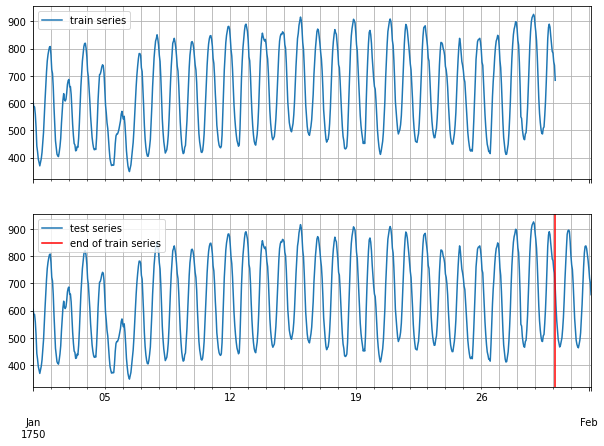

In [9]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [10]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## 1.2 Crear conjunto de datos artificiales

Podemos crear fácilmente un conjunto de datos de series de tiempo artificiales complejas usando el módulo `ComplexSeasonalTimeSeries`.

In [11]:
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

In [12]:
artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=21,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10000,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

Podemos acceder a algunos metadatos importantes del conjunto de datos artificiales de la siguiente manera:



In [13]:
print(f"prediction length: {artificial_dataset.metadata.prediction_length}")
print(f"frequency: {artificial_dataset.metadata.freq}")

prediction length: 21
frequency: H


El conjunto de datos artificiales que creamos es una lista de diccionarios. Cada diccionario corresponde a una serie temporal y debe contener los campos obligatorios.

In [14]:
print(f"type of train dataset: {type(artificial_dataset.train)}")
print(f"train dataset fields: {artificial_dataset.train[0].keys()}")
print(f"type of test dataset: {type(artificial_dataset.test)}")
print(f"test dataset fields: {artificial_dataset.test[0].keys()}")

type of train dataset: <class 'list'>
train dataset fields: dict_keys(['start', 'target', 'item_id'])
type of test dataset: <class 'list'>
test dataset fields: dict_keys(['start', 'target', 'item_id'])


Para utilizar los conjuntos de datos creados artificialmente (lista de diccionarios), necesitamos convertirlos en objetos `ListDataset`.

In [15]:
train_ds = ListDataset(artificial_dataset.train, 
                        freq=artificial_dataset.metadata.freq)

In [16]:
test_ds = ListDataset(artificial_dataset.test, 
                       freq=artificial_dataset.metadata.freq)

In [17]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['start', 'target', 'item_id', 'source'])

In [18]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['start', 'target', 'item_id', 'source'])

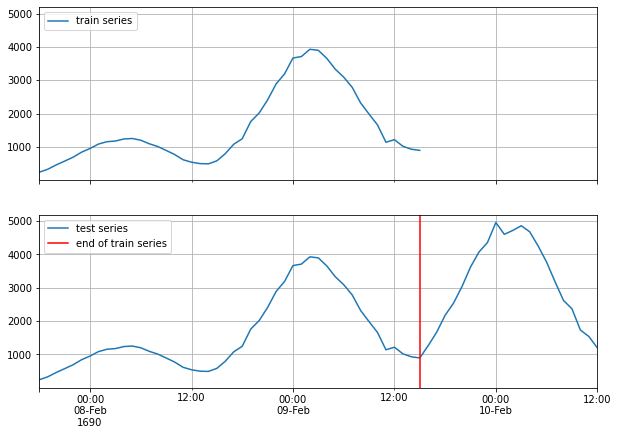

In [19]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## 1.3 Usar tu serie de tiempo y sus variables

Ahora, veremos cómo podemos convertir cualquier conjunto de datos personalizado con cualquier característica asociada a un formato apropiado para GluonTS.

Como ya se mencionó, se requiere que un conjunto de datos tenga al menos los campos `target` y` start`. Sin embargo, puede tener más. Veamos cuáles son todos los campos disponibles:

In [20]:
from gluonts.dataset.field_names import FieldName

In [21]:
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

Los campos se dividen en tres categorías: los obligatorios, los opcionales y los que se pueden agregar mediante la `Transformación` (explicado en un momento).

Requerido:

- `start`: fecha de inicio de la serie temporal
- `target`: valores de la serie temporal

Opcional:

- `feat_static_cat`: características categóricas estáticas (a lo largo del tiempo), lista con una dimensión igual al número de características
- `feat_static_real`: características reales estáticas (a lo largo del tiempo), lista con una dimensión igual al número de características
- `feat_dynamic_cat`: características categóricas dinámicas (a lo largo del tiempo), matriz con forma igual a (número de características, longitud objetivo)
- `feat_dynamic_real`: características reales dinámicas (a lo largo del tiempo), matriz con forma igual a (número de características, longitud objetivo)

Agregado por `Transformación`:

- `time_feat`: características relacionadas con el tiempo, como el mes o el día
- `feat_dynamic_const`: expande una característica de valor constante a lo largo del eje del tiempo
- `feat_dynamic_age`: característica de edad, es decir, una característica cuyo valor es pequeño para marcas de tiempo pasadas distantes y aumenta monótonamente cuanto más nos acercamos a la marca de tiempo actual
- `valores_observados`: indicador de valores observados, es decir, una característica que es igual a 1 si se observa el valor y 0 si falta el valor
- `is_pad`: indicador para cada paso de tiempo que muestra si está relleno (si la longitud no es suficiente)
- `forecast_start`: fecha de inicio del pronóstico

Como ejemplo simple, podemos crear un conjunto de datos personalizado para ver cómo podemos usar algunos de estos campos. El conjunto de datos consta de un objetivo, una característica dinámica real (que en este ejemplo establecimos como el valor objetivo un período antes) y una característica categórica estática que indica el tipo de sinusoide (fase diferente) que usamos para crear el objetivo.

In [22]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern    
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))
    
    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))
    
    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1), 
                                      (int(np.ceil(num_series / 2)),1)), 
                              np.tile(sin_Zero_2Pi.reshape(1, -1), 
                                      (int(np.floor(num_series / 2)), 1))
                             ),
                             axis=0
                            )
    
    target = noise + pattern
    
    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)), 
                                        target[:, :-period]
                                       ), 
                                       axis=1
                                      )
    
    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))), 
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )
    
    return target, feat_dynamic_real, feat_static_cat
    

In [23]:
# define the parameters of the dataset
custom_ds_metadata = {'num_series': 100,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H') 
                                for _ in range(100)]
                     }

In [24]:
data_out = create_dataset(custom_ds_metadata['num_series'], 
                          custom_ds_metadata['num_steps'],                                                      
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_real, feat_static_cat = data_out

Podemos crear fácilmente los conjuntos de datos de prueba y entrenamiento simplemente completando los campos correctos. Recuerde que para el conjunto de datos de entrenamiento debemos cortar la última ventana.

In [25]:
train_ds = ListDataset([{FieldName.TARGET: target, 
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: [fdr],
                         FieldName.FEAT_STATIC_CAT: [fsc]} 
                        for (target, start, fdr, fsc) in zip(target[:, :-custom_ds_metadata['prediction_length']], 
                                                             custom_ds_metadata['start'], 
                                                             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']], 
                                                             feat_static_cat)],
                      freq=custom_ds_metadata['freq'])

In [26]:
test_ds = ListDataset([{FieldName.TARGET: target, 
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_REAL: [fdr],
                        FieldName.FEAT_STATIC_CAT: [fsc]} 
                       for (target, start, fdr, fsc) in zip(target, 
                                                            custom_ds_metadata['start'], 
                                                            feat_dynamic_real, 
                                                            feat_static_cat)],
                     freq=custom_ds_metadata['freq'])

Ahora, podemos examinar cada entrada de los conjuntos de datos de entrenamiento y prueba. Deberíamos esperar que tengan los siguientes campos: `target`,` start`, `feat_dynamic_real` y` feat_static_cat`.



In [27]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

In [28]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

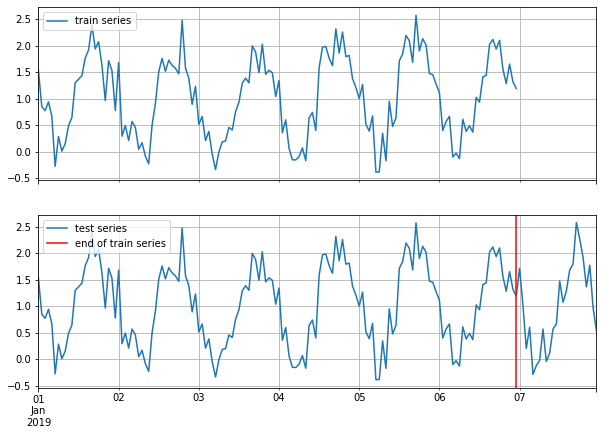

In [29]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

<span style="color:red">*Para el resto del tutorial usaremos el conjunto de datos generado*</span>

# 2. Transformaciones

## 2.1 Definir transformaciones

El caso de uso principal para una "Transformación" es para el procesamiento de características, por ejemplo, agregar una característica de vacaciones y para definir la forma en que el conjunto de datos se dividirá en las ventanas apropiadas durante el entrenamiento y la inferencia.

En general, obtiene una colección iterable de entradas de un conjunto de datos y la transforma en otra colección iterable que posiblemente pueda contener más campos. La transformación se realiza mediante la definición de un conjunto de "acciones" para el conjunto de datos sin procesar dependiendo de lo que sea útil para nuestro modelo. Estas acciones generalmente crean algunas características adicionales o transforman una característica existente. Como ejemplo, a continuación agregamos las siguientes transformaciones:

- `AddObservedValuesIndicator`: Crea el campo `observed_values` en el conjunto de datos, es decir, agrega una característica que es igual a 1 si se observa el valor y 0 si falta el valor
- `AddAgeFeature`: Crea el campo` feat_dynamic_age` en el conjunto de datos, es decir, agrega una característica de que su valor es pequeño para marcas de tiempo pasadas distantes y aumenta monótonamente cuanto más nos acercamos a la marca de tiempo actual

Es posible que la "Transformación" no defina un campo adicional en el conjunto de datos. Sin embargo, ** siempre ** debe definir cómo se dividirán los conjuntos de datos en ventanas de ejemplo durante el entrenamiento y las pruebas. Esto se hace con el `InstanceSplitter` que se configura de la siguiente manera (omitiendo los campos obvios):

- `is_pad_field`: indicador si la serie temporal está rellenada (si la longitud no es suficiente)
- `train_sampler`: define cómo se cortan / muestrean las ventanas de entrenamiento
- `time_series_fields`: contiene las características dependientes del tiempo que deben dividirse de la misma manera que el objetivo

In [30]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

In [31]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

## 2.2 Transformar el dataset

Ahora, podemos crear un objeto de transformación aplicando la transformación anterior al conjunto de datos personalizado que hemos creado.

In [32]:
transformation = create_transformation(custom_ds_metadata['freq'], 
                                       2 * custom_ds_metadata['prediction_length'], # can be any appropriate value
                                       custom_ds_metadata['prediction_length'])

In [33]:
train_tf = transformation(iter(train_ds), is_train=True)

In [34]:
type(train_tf)

generator

Como era de esperar, la salida es otro objeto iterable. Podemos examinar fácilmente lo que contiene una entrada del conjunto de datos transformado. Cuando `is_train = True` en la transformación, el` InstanceSplitter` itera sobre el conjunto de datos transformado y corta las ventanas seleccionando aleatoriamente una serie de tiempo y un punto de partida en esa serie de tiempo (esta "aleatoriedad" está definida por el `train_sampler`).

In [35]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

El transformador ha hecho lo que le pedimos. En particular, ha agregado:

- un campo para valores observados (`valores_observados`)
- un campo para la característica de edad (`feat_dynamic_age`)
- algunos campos adicionales útiles (`past_is_pad`,` forecast_start`)

Ha hecho una cosa más importante: ha dividido la ventana en pasado y futuro y ha agregado los prefijos correspondientes a todos los campos dependientes del tiempo. De esta manera podemos usar fácilmente, por ejemplo, el campo `past_target` como entrada y el campo` future_target` para calcular el error de nuestras predicciones. Por supuesto, la duración del pasado es igual a la `context_length` y la del futuro es igual a la` prediction_length`.

In [36]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print(train_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


Como punto de comparación, veamos nuevamente cuáles eran los campos en el conjunto de datos original antes de la transformación:

In [37]:
[k for k in next(iter(train_ds)).keys()]

['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source']

Ahora, podemos seguir adelante y ver cómo se divide el conjunto de datos de prueba. Como vimos, la transformación divide las ventanas hacia el pasado y el futuro. Sin embargo, durante la inferencia (`is_train = False` en la transformación), el divisor siempre corta la última ventana (de longitud` context_length`) del conjunto de datos para poder predecir los valores desconocidos posteriores de longitud `prediction_length`.

Entonces, ¿cómo se divide el conjunto de datos de prueba en el pasado y el futuro, ya que no conocemos el objetivo futuro? ¿Y qué hay de las funciones dependientes del tiempo?

In [38]:
test_tf = transformation(iter(test_ds), is_train=False)

In [39]:
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [40]:
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")
print(test_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (0,)
past observed values shape: (48,)
future observed values shape: (0,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


El objetivo futuro está vacío, pero no las funciones; ¡siempre asumimos que conocemos las funciones futuras!

Todas las cosas que hicimos manualmente aquí las hace un bloque interno llamado `DataLoader`. Obtiene como entrada el conjunto de datos sin procesar (en el formato apropiado) y el objeto de transformación y genera el conjunto de datos iterables transformado lote por lote. ¡Lo único de lo que debemos preocuparnos es configurar los campos de transformación correctamente!

# 3. Entrenar un modelo existente

GluonTS viene con varios modelos prediseñados. Todo lo que el usuario necesita hacer es configurar algunos hiperparámetros. Los modelos existentes se centran en (pero no se limitan a) la predicción probabilística. Los pronósticos probabilísticos son predicciones en forma de distribución de probabilidad, en lugar de una simple estimación puntual. Habiendo estimado la distribución futura de cada paso de tiempo en el horizonte de pronóstico, podemos extraer una muestra de la distribución en cada paso de tiempo y así crear una "ruta de muestra" que puede verse como una posible realización del futuro. En la práctica, extraemos múltiples muestras y creamos múltiples rutas de muestra que se pueden usar para visualización, evaluación del modelo, para derivar estadísticas, etc.

## 3.1 Configurar un predictor

Comenzaremos con el estimador de redes neuronales feedforward preconstruido de GulonTS, un modelo de pronóstico simple pero poderoso. Usaremos este modelo para demostrar el proceso de entrenar un modelo, producir pronósticos y evaluar los resultados.

La red neuronal feedforward incorporada de GluonTS (`SimpleFeedForwardEstimator`) acepta una ventana de entrada de longitud` context_length` y predice la distribución de los valores de los valores de `prediction_length` subsiguientes. En el lenguaje de GluonTS, el modelo de red neuronal feedforward es un ejemplo de "Estimador". En GluonTS, los objetos `Estimator` representan un modelo de pronóstico, así como detalles como sus coeficientes, pesos, etc.

En general, cada estimador (prediseñado o personalizado) está configurado por una serie de hiperparámetros que pueden ser comunes (pero no vinculantes) entre todos los estimadores (p. Ej., `Prediction_length`) o específicos para el estimador particular (p. Ej., Number de capas para una red neuronal o el paso en una CNN).

Finalmente, cada estimador es configurado por un `Trainer`, que define cómo se entrenará el modelo, es decir, el número de épocas, la tasa de aprendizaje, etc.

In [41]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: gluonts.trainer is deprecated. Use gluonts.mx.trainer instead.
  


In [42]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100
                   )
)

## 3.2 Cargar el predictor

Después de especificar nuestro estimador con todos los hiperparámetros necesarios, podemos entrenarlo usando nuestro conjunto de datos de entrenamiento `dataset.train` invocando el método` train` del estimador. El algoritmo de entrenamiento devuelve un modelo ajustado (o un "Predictor" en el lenguaje de GluonTS) que se puede usar para construir pronósticos.

Debemos enfatizar aquí que un solo modelo, como el definido anteriormente, se entrena sobre todas las series de tiempo contenidas en el conjunto de datos de entrenamiento `train_ds`. Esto da como resultado un modelo **global**, adecuado para la predicción de todas las series de tiempo en `train_ds` y posiblemente para otras series de tiempo relacionadas no vistas.

In [43]:
predictor = estimator.train(train_ds)

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:01<00:00, 63.36it/s, epoch=5/5, avg_epoch_loss=0.623]


## 3.3 Guardado/cargado de modeo

Un modelo ajustado, es decir, un "Predictor", se puede guardar y volver a cargar fácilmente:

In [44]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

In [45]:
# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

# 4. Evaluación

## 4.1 Obtener proyecciones

Con un predictor en la mano, ahora podemos predecir la última ventana del `dataset.test` y evaluar el rendimiento de nuestro modelo.

GluonTS viene con la función `make_evaluation_predictions` que automatiza el proceso de predicción y evaluación del modelo. Aproximadamente, esta función realiza los siguientes pasos:

- Elimina la ventana final de longitud `prediction_length` del` dataset.test` que queremos predecir
- El estimador utiliza los datos restantes para predecir (en forma de rutas de muestra) la ventana "futura" que se acaba de eliminar.
- El módulo genera las rutas de muestra de pronóstico y el `dataset.test` (como objetos generadores de Python)

In [46]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [47]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

Primero, podemos convertir estos generadores en listas para facilitar los cálculos posteriores.



In [48]:
forecasts = list(forecast_it)
tss = list(ts_it)

Podemos examinar el primer elemento de estas listas (que corresponde a la primera serie de tiempo del conjunto de datos). Comencemos con la lista que contiene la serie temporal, es decir, `tss`. Esperamos que la primera entrada de `tss` contenga el (objetivo de la) primera serie temporal de` test_ds`.

In [49]:
# El primer registro de la serie de tiempo
ts_entry = tss[0]

In [50]:
# Primeros 5 valores de la serie de tiempo (convertir de pandas a numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([1.5292157 , 0.85025036, 0.7740374 , 0.941432  , 0.6723822 ],
      dtype=float32)

In [51]:
# Primer registro de test_ds
test_ds_entry = next(iter(test_ds))

In [52]:
# Primeros 5 valores
test_ds_entry['target'][:5]

array([1.5292157 , 0.85025036, 0.7740374 , 0.941432  , 0.6723822 ],
      dtype=float32)

Las entradas en la lista de "previsión" son un poco más complejas. Son objetos que contienen todas las rutas de muestra en forma de `numpy.ndarray` con dimensión` (num_samples, prediction_length) `, la fecha de inicio de la previsión, la frecuencia de la serie temporal, etc. Podemos acceder a toda esta información simplemente invocando el atributo correspondiente del objeto de pronóstico.

In [53]:
# Primer registro de la lista de proyección
forecast_entry = forecasts[0]

In [54]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2019-01-07 00:00:00
Frequency of the time series: 1H


También podemos hacer cálculos para resumir las rutas de la muestra, como calcular la media o un cuantil para cada uno de los 24 pasos de tiempo en la ventana de pronóstico.

In [55]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 0.86054766  0.6159482   0.51599747  0.44300053  0.24408728 -0.06396255
  0.07537311  0.37274835  0.2259041   0.34221733  0.6369963   0.76361984
  1.2630339   1.493244    1.635315    1.850508    1.7365319   1.8068124
  1.9704094   1.8011847   1.7296803   1.5309474   1.2304064   1.105966  ]
0.5-quantile (median) of the future window:
 [ 0.8730909   0.6443132   0.47843203  0.4041104   0.28385893 -0.0694565
  0.11234318  0.35089526  0.16843078  0.36027095  0.6652443   0.8028993
  1.2262872   1.3020331   1.6141962   1.8728552   1.7287005   1.8047898
  2.0245717   1.780743    1.7747396   1.5458498   1.2782309   1.1061883 ]


Los objetos de pronóstico tienen un método de trazado que puede resumir las rutas de pronóstico como la media, los intervalos de predicción, etc. Los intervalos de predicción están sombreados en diferentes colores como un "gráfico de abanico".



In [56]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

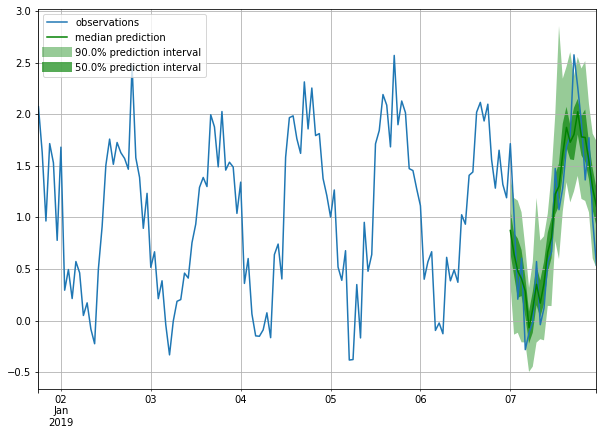

In [57]:
plot_prob_forecasts(ts_entry, forecast_entry)

## 4.2 Calcular métricas

También podemos evaluar numéricamente la calidad de nuestros pronósticos. En GluonTS, la clase `Evaluator` puede calcular métricas de rendimiento agregadas, así como métricas por serie de tiempo (que pueden ser útiles para analizar el rendimiento en series de tiempo heterogéneas).

In [58]:
from gluonts.evaluation import Evaluator

In [59]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 3285.04it/s]


Las métricas agregadas se agregan tanto a través de pasos de tiempo como a través de series de tiempo.

In [60]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.11689357042312619,
    "abs_error": 652.0211925506592,
    "abs_target_sum": 2505.765546798706,
    "abs_target_mean": 1.0440689778327943,
    "seasonal_error": 0.3378558193842571,
    "MASE": 0.8110764760561573,
    "MAPE": 3.375894165338201,
    "sMAPE": 0.5202943320354214,
    "OWA": NaN,
    "MSIS": 5.635922094218684,
    "QuantileLoss[0.1]": 288.9994254309684,
    "Coverage[0.1]": 0.11666666666666668,
    "QuantileLoss[0.5]": 652.0211927611381,
    "Coverage[0.5]": 0.5545833333333333,
    "QuantileLoss[0.9]": 305.49796901941295,
    "Coverage[0.9]": 0.907083333333333,
    "RMSE": 0.34189701727731725,
    "NRMSE": 0.3274659285318517,
    "ND": 0.26020837958430015,
    "wQuantileLoss[0.1]": 0.115333785237883,
    "wQuantileLoss[0.5]": 0.260208379668298,
    "wQuantileLoss[0.9]": 0.12191801799242885,
    "mean_absolute_QuantileLoss": 415.50619573717313,
    "mean_wQuantileLoss": 0.1658200609662033,
    "MAE_Coverage": 0.026111111111110998
}


Las métricas individuales se agregan solo a través de pasos de tiempo.

In [61]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,0.130021,7.043859,24.638548,1.026606,0.351642,0.834640,0.961615,0.552452,NaN,6.782110,2.508494,0.083333,7.043859,0.583333,3.760772,0.916667
1,NaN,0.118082,6.200833,22.178631,0.924110,0.340241,0.759367,2.178547,0.587683,NaN,5.766935,2.675090,0.083333,6.200833,0.750000,3.058608,0.916667
2,NaN,0.126092,6.321708,26.601139,1.108381,0.323560,0.814083,0.338865,0.387058,NaN,6.787339,3.120923,0.083333,6.321708,0.458333,3.126290,0.916667
3,NaN,0.125740,6.234529,22.502333,0.937597,0.311026,0.835210,0.916487,0.484879,NaN,7.236084,3.308530,0.208333,6.234529,0.583333,3.390347,0.958333
4,NaN,0.083647,4.866461,25.864388,1.077683,0.313119,0.647578,1.320937,0.477489,NaN,6.364174,2.354546,0.041667,4.866461,0.541667,2.946430,0.916667


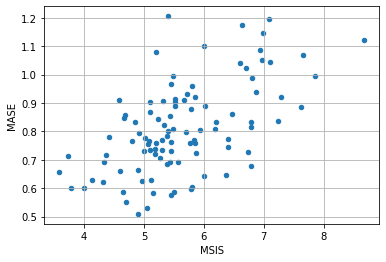

In [62]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# 5. Crea tu propio modelo

Para crear nuestro propio modelo de pronóstico, necesitamos:

- Definir la red de entrenamiento y predicción
- Definir un nuevo estimador que especifique cualquier procesamiento de datos y utilice las redes.

Las redes de entrenamiento y predicción pueden ser arbitrariamente complejas pero deben seguir algunas reglas básicas:

- Ambos deben tener un método `hybrid_forward` que defina lo que debe suceder cuando se llama a la red
- El `hybrid_forward` de la red de entrenamiento debería devolver una **pérdida** según la predicción y los valores reales
- El `hybrid_forward` de la red de predicción debería devolver las predicciones

El estimador también debe seguir algunas reglas:

- Debe incluir un método `create_transformation` que defina todas las posibles transformaciones de características y cómo se dividen los datos durante el entrenamiento.
- Debe incluir un método `create_training_network` que devuelva la red de entrenamiento configurada con los hiperparámetros necesarios
- Debe incluir un método `create_predictor` que cree la red de predicción y devuelva un objeto` Predictor`

Un `Predictor` define el método` predictor.predict` de un predictor dado. Este método toma el conjunto de datos de prueba, lo pasa a través de la red de predicción para tomar las predicciones y produce las predicciones. Puede pensar en el objeto "Predictor" como un envoltorio de la red de predicción que define su método "predictor".

En esta sección, comenzaremos de manera simple creando una red de retroalimentación que está restringida a pronósticos puntuales. Luego, agregaremos complejidad a la red expandiéndola al pronóstico probabilístico, considerando características y escalado de la serie de tiempo, y al final lo reemplazaremos con un RNN.

Necesitamos enfatizar que la forma en que se implementan los siguientes modelos y todas las elecciones de diseño que se toman no son vinculantes ni necesariamente óptimas. Su único propósito es proporcionar pautas y sugerencias sobre cómo construir un modelo.
## 5.1 Pronósticos puntuales con una simple red feedforward

Podemos crear una red de entrenamiento simple que defina una red neuronal que toma como entrada una ventana de longitud `context_length` y predice la ventana subsiguiente de dimensión` prediction_length` (por lo tanto, la dimensión de salida de la red es `prediction_length`). El método `hybrid_forward` de la red de entrenamiento devuelve la media de la pérdida L1.

La red de predicción es (y debería ser) idéntica a la red de entrenamiento (al heredar la clase) y su método `hybrid_forward` devuelve las predicciones.

In [63]:
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells
    
        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))


class MyTrainNetwork(MyNetwork):    
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

La clase de estimador está configurada por unos pocos hiperparámetros e implementa los métodos requeridos.

In [64]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.trainer import Trainer
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter
from mxnet.gluon import HybridBlock

In [65]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        num_cells: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.num_cells = num_cells
            
    def create_transformation(self):
        # Feature transformation that the model uses for input
        # Here we use a transformation that defines only how the train and test windows are cut
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )
    
    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

Después de definir la red de entrenamiento y predicción, así como la clase de estimador, podemos seguir exactamente los mismos pasos que con los modelos existentes, es decir, podemos especificar nuestro estimador pasando todos los hiperparámetros requeridos a la clase de estimador, entrenar el estimador por invocando su método `train` para crear un predictor, y finalmente use la función` make_evaluation_predictions` para generar nuestros pronósticos.

In [66]:
estimator = MyEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    num_cells=40,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100
                   )
)

El estimador se puede entrenar usando nuestro conjunto de datos de entrenamiento `train_ds` simplemente invocando su método` train`. El entrenamiento devuelve un predictor que se puede usar para predecir.

In [67]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 134.06it/s, epoch=5/5, avg_epoch_loss=0.289]


In [68]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [69]:
forecasts = list(forecast_it)
tss = list(ts_it)

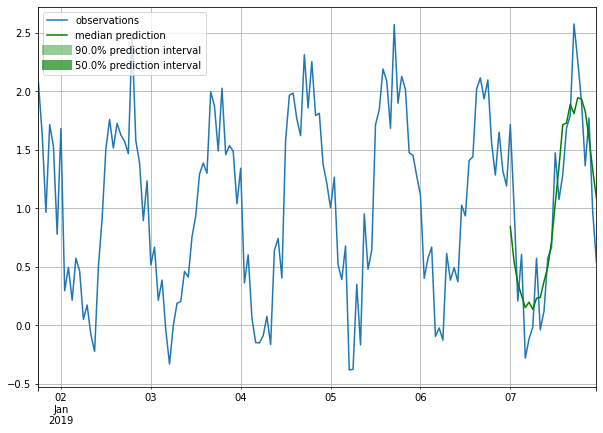

In [70]:
plot_prob_forecasts(tss[0], forecasts[0])

Observe que en realidad no podemos ver ningún intervalo de predicción en las predicciones. Esto se espera ya que el modelo que definimos no realiza pronósticos probabilísticos, sino que solo proporciona estimaciones puntuales. Al requerir 100 rutas de muestra (definidas en `make_evaluation_predictions`) en dicha red, obtenemos 100 veces la misma salida.

## 5.2 Pronóstico probabilístico

### 5.2.1 ¿Cómo aprende un modelo una distribución?

El pronóstico probabilístico requiere que aprendamos la distribución de los valores futuros de la serie de tiempo y no los valores en sí mismos como en el pronóstico puntual. Para lograr esto, necesitamos especificar el tipo de distribución que siguen los valores futuros. GluonTS viene con una serie de distribuciones diferentes que cubren muchos casos de uso, como Gaussian, Student-t y Uniform, solo por nombrar algunos.


Para aprender una distribución, necesitamos aprender sus parámetros. Por ejemplo, en el caso simple en el que asumimos una distribución gaussiana, necesitamos aprender la media y la varianza que especifican completamente la distribución.

Cada distribución que está disponible en GluonTS está definida por la clase correspondiente de "Distribución" (por ejemplo, "Gaussiano"). Esta clase define -entre otras- los parámetros de la distribución, su (log-) verosimilitud y un método de muestreo (dados los parámetros).

Sin embargo, no es sencillo conectar un modelo con dicha distribución y aprender sus parámetros. Para esto, cada distribución viene con una clase `DistributionOutput` (por ejemplo,` GaussianOutput`). El papel de esta clase es conectar un modelo con una distribución. Su uso principal es tomar la salida del modelo y asignarla a los parámetros de la distribución. Puede pensar en ello como una capa de proyección adicional en la parte superior del modelo. Los parámetros de esta capa se optimizan junto con el resto de la red.

Al incluir esta capa de proyección, nuestro modelo aprende de manera efectiva los parámetros de la distribución (elegida) de cada paso de tiempo. Por lo general, este modelo se optimiza eligiendo como función de pérdida la probabilidad logarítmica negativa de la distribución elegida. Después de optimizar nuestro modelo y aprender los parámetros, podemos muestrear o derivar cualquier otra estadística útil de las distribuciones aprendidas.

### 5.2.2 Red de feedforward para pronósticos probabilísticos

Veamos qué cambios necesitamos hacer en el modelo anterior para que sea probabilístico:

- Primero, necesitamos cambiar la salida de la red. En la red de pronóstico puntual, la salida fue un vector de longitud `prediction_length` que proporcionó directamente las estimaciones puntuales. Ahora, necesitamos generar un conjunto de características que el `DistributionOutput` usará para proyectar los parámetros de distribución. Estas características deben ser diferentes para cada paso de tiempo en el horizonte de predicción. Por lo tanto, necesitamos una salida general de valores de `prediction_length * num_features`.
- El `DistributionOutput` toma como entrada un tensor y usa la última dimensión como características para ser proyectadas a los parámetros de distribución. Aquí, necesitamos un objeto de distribución para cada paso de tiempo, es decir, objetos de distribución `prediction_length`. Dado que la salida de la red tiene valores de `prediction_length * num_features`, podemos remodelarla a` (prediction_length, num_features) `y obtener las distribuciones requeridas, mientras que el último eje de longitud` num_features` se proyectará a los parámetros de distribución.
- Queremos que la red de predicción genere muchas rutas de muestra para cada serie de tiempo. Para lograr esto, podemos repetir cada serie de tiempo tantas veces como el número de rutas de muestra y hacer un pronóstico estándar para cada una de ellas.

Tenga en cuenta que en todos los tensores que manejamos hay una dimensión inicial que se refiere al lote, por ejemplo, la salida de la red tiene dimensión `(tamaño_de_lote, longitud_de_previsión * num_features)`.

In [71]:
from gluonts.distribution.distribution_output import DistributionOutput
from gluonts.distribution.gaussian import GaussianOutput

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: gluonts.distribution is deprecated. Use gluonts.mx.distribution instead.
  """Entry point for launching an IPython kernel.


In [72]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(self, 
                 prediction_length, 
                 distr_output, 
                 num_cells, 
                 num_sample_paths=100, 
                 **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))


class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        # compute network output
        net_output = self.nn(past_target)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss


class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        # repeat past target: from (batch_size, past_target_length) to 
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        
        # compute network output
        net_output = self.nn(repeated_past_target)

        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)
       
        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()
        
        # reshape from (batch_size * num_sample_paths, prediction_length) to 
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

The changes we need to do at the estimator are minor and they mainly reflect the additional `distr_output` parameter that our networks use.

In [73]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
            self,
            prediction_length: int,
            context_length: int,
            freq: str,
            distr_output: DistributionOutput,
            num_cells: int,
            num_sample_paths: int = 100,
            trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths

    def create_transformation(self):
        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            train_sampler=ExpectedNumInstanceSampler(num_instances=1),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

    def create_predictor(
            self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [74]:
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100
                   )
)

In [75]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 100.05it/s, epoch=5/5, avg_epoch_loss=0.344]


In [76]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [77]:
forecasts = list(forecast_it)
tss = list(ts_it)

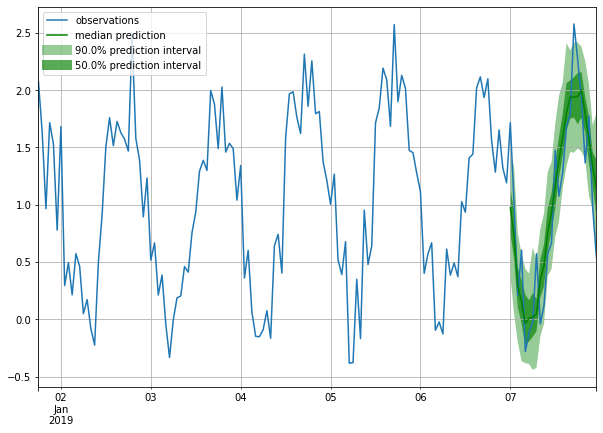

In [78]:
plot_prob_forecasts(tss[0], forecasts[0])

## 5.3 Agregar y escalar variables

En las redes anteriores usamos solo el objetivo y no aprovechamos ninguna de las características del conjunto de datos. Aquí expandimos la red probabilística al incluir el campo `feat_dynamic_real` del conjunto de datos que podría mejorar el poder de pronóstico de nuestro modelo. Logramos esto concatenando el objetivo y las características a un vector mejorado que forma la nueva entrada de red.

Todas las características que están disponibles en un conjunto de datos se pueden usar potencialmente como entradas para nuestro modelo. Sin embargo, a los efectos de este ejemplo, nos limitaremos a utilizar una sola función.

Un tema importante con el que un profesional debe lidiar a menudo son los diferentes órdenes de magnitud en los valores de las series de tiempo en un conjunto de datos. Es extremadamente útil entrenar un modelo y pronosticar valores que se encuentran aproximadamente en el mismo rango de valores. Para abordar este problema, agregamos un "Escalador" al modelo, que calcula la escala de cada serie de tiempo. Luego, podemos escalar en consecuencia los valores de la serie de tiempo o cualquier característica relacionada y usarlos como entradas a la red.

In [79]:
from gluonts.block.scaler import MeanScaler, NOPScaler

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: gluonts.block is deprecated. Use gluonts.mx.block instead.
  """Entry point for launching an IPython kernel.


In [80]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(self, 
                 prediction_length, 
                 context_length, 
                 distr_output, 
                 num_cells, 
                 num_sample_paths=100, 
                 scaling=True, 
                 **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()
        self.scaling = scaling

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))

            if scaling:
                self.scaler = MeanScaler(keepdims=True)
            else:
                self.scaler = NOPScaler(keepdims=True)

    def compute_scale(self, past_target, past_observed_values):
        # scale shape is (batch_size, 1)
        _, scale = self.scaler(
            past_target.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            past_observed_values.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
        )

        return scale


class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target, past_observed_values, past_feat_dynamic_real):
        # compute scale 
        scale = self.compute_scale(past_target, past_observed_values)

        # scale target and time features
        past_target_scale = F.broadcast_div(past_target, scale)
        past_feat_dynamic_real_scale = F.broadcast_div(past_feat_dynamic_real.squeeze(axis=-1), scale)

        # concatenate target and time features to use them as input to the network
        net_input = F.concat(past_target_scale, past_feat_dynamic_real_scale, dim=-1)

        # compute network output
        net_output = self.nn(net_input)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss


class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target, past_observed_values, past_feat_dynamic_real):
        # repeat fields: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        repeated_past_observed_values = past_observed_values.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        repeated_past_feat_dynamic_real = past_feat_dynamic_real.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        
        # compute scale
        scale = self.compute_scale(repeated_past_target, repeated_past_observed_values)

        # scale repeated target and time features
        repeated_past_target_scale = F.broadcast_div(repeated_past_target, scale)
        repeated_past_feat_dynamic_real_scale = F.broadcast_div(repeated_past_feat_dynamic_real.squeeze(axis=-1), scale)

        # concatenate target and time features to use them as input to the network
        net_input = F.concat(repeated_past_target_scale, repeated_past_feat_dynamic_real_scale, dim=-1)

        # compute network oputput
        net_output = self.nn(net_input)
        
        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)
        
        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()

        # reshape from (batch_size * num_sample_paths, prediction_length) to
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

In [81]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
            self,
            prediction_length: int,
            context_length: int,
            freq: str,
            distr_output: DistributionOutput,
            num_cells: int,
            num_sample_paths: int = 100,
            scaling: bool = True,
            trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.scaling = scaling

    def create_transformation(self):
        # Feature transformation that the model uses for input.
        return Chain(
            [
                AddObservedValuesIndicator(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.OBSERVED_VALUES,
                ),
                InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                    time_series_fields=[
                        FieldName.FEAT_DYNAMIC_REAL,
                        FieldName.OBSERVED_VALUES,
                    ],
                ),

            ]
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

    def create_predictor(
            self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [82]:
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100
                   )
)

In [83]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:01<00:00, 67.85it/s, epoch=5/5, avg_epoch_loss=0.423]


In [84]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [85]:
forecasts = list(forecast_it)
tss = list(ts_it)

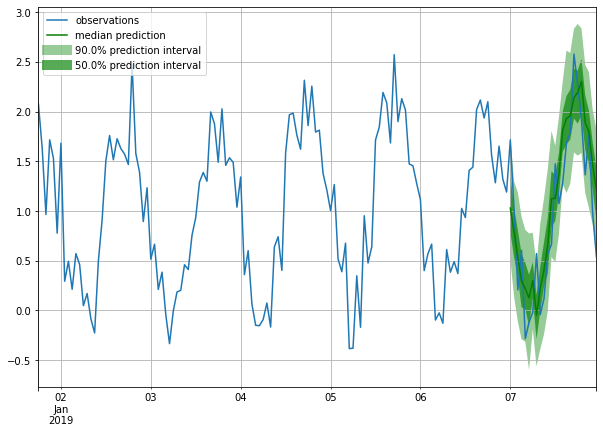

In [86]:
plot_prob_forecasts(tss[0], forecasts[0])

## 5.4 De feedforward a RNN

En todos los ejemplos anteriores, hemos utilizado una red neuronal feedforward como base para nuestro modelo de pronóstico. La idea principal detrás de esto era usar como entrada a la red una ventana de la serie de tiempo (de longitud `context_length`) y entrenar a la red para pronosticar la siguiente ventana (de longitud` prediction_length`).

En esta sección reemplazaremos la red feedforward con una red neuronal recurrente (RNN). Debido a la diferente naturaleza de las RNN, la estructura de las redes será un poco diferente. Veamos cuáles son los cambios más importantes.

### 5.4.1 Entrenamiento

La idea principal detrás de RNN es la misma que en las redes de retroalimentación que ya construimos: a medida que desenrollamos el RNN en cada paso de tiempo, usamos como entrada los valores pasados ​​de la serie de tiempo y pronosticamos el siguiente valor. Podemos mejorar la entrada utilizando múltiples valores pasados ​​(por ejemplo, retrasos específicos basados ​​en patrones de estacionalidad) o características disponibles. Sin embargo, en este ejemplo mantendremos las cosas simples y solo usaremos el último valor de la serie de tiempo. La salida de la red en cada paso de tiempo es la distribución del valor del siguiente paso de tiempo, donde el estado del RNN se usa como vector de características para la proyección de parámetros de la distribución.

Debido a la naturaleza secuencial de la RNN, la distinción entre `pasado_` y` futuro_` en la ventana de corte de la serie temporal no es realmente necesaria. Por lo tanto, podemos concatenar `past_target` y` future_target `y tratarlo como una ventana concreta de` target` que deseamos pronosticar. Esto significa que la entrada al RNN sería (secuencialmente) la ventana `target [- (context_length + prediction_length + 1): - 1]` (un paso de tiempo antes de la ventana que queremos predecir). Como consecuencia, necesitamos tener `context_length + prediction_length + 1` valores disponibles en cada ventana que cortamos. Podemos definir esto en el `InstanceSplitter`.

En general, durante el entrenamiento, los pasos son los siguientes:

- Pasamos secuencialmente a través del RNN los valores objetivo `target [- (context_length + prediction_length + 1): - 1]`
- Usamos el estado del RNN en cada paso de tiempo como un vector de características y lo proyectamos al dominio de parámetros de distribución.
- La salida en cada paso de tiempo es la distribución de los valores del siguiente paso de tiempo, que en general es la distribución prevista para la ventana `target [- (context_length + prediction_length):]`

Los pasos anteriores se implementan en el método `unroll_encoder`.

### 5.4.2 Inferencia

Durante la inferencia solo conocemos los valores de `past_target`, por lo que no podemos seguir exactamente los mismos pasos que en el entrenamiento. Sin embargo, la idea principal es muy similar:

- Pasamos secuencialmente a través del RNN los valores objetivo pasados ​​`past_target [- (context_length + 1):]` que actualiza efectivamente el estado del RNN
- En el último paso de tiempo, la salida del RNN es efectivamente la distribución del siguiente valor de la serie de tiempo (que no conocemos). Por lo tanto, tomamos muestras (`num_sample_paths` veces) de esta distribución y usamos las muestras como entradas al RNN para el próximo paso de tiempo
- Repetimos el paso anterior `prediction_length` veces

El primer paso se implementa en `unroll_encoder` y los últimos pasos en el método` sample_decoder`.

In [87]:
class MyProbRNN(gluon.HybridBlock):
    def __init__(self,
                 prediction_length,
                 context_length,
                 distr_output,
                 num_cells,
                 num_layers,
                 num_sample_paths=100,
                 scaling=True,
                 **kwargs
     ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_layers = num_layers
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()
        self.scaling = scaling

        with self.name_scope():
            self.rnn = mx.gluon.rnn.HybridSequentialRNNCell()
            for k in range(self.num_layers):
                cell = mx.gluon.rnn.LSTMCell(hidden_size=self.num_cells)
                cell = mx.gluon.rnn.ResidualCell(cell) if k > 0 else cell
                self.rnn.add(cell)

            if scaling:
                self.scaler = MeanScaler(keepdims=True)
            else:
                self.scaler = NOPScaler(keepdims=True)

    def compute_scale(self, past_target, past_observed_values):
        # scale is computed on the context length last units of the past target
        # scale shape is (batch_size, 1, *target_shape)
        _, scale = self.scaler(
            past_target.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            past_observed_values.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
        )

        return scale

    def unroll_encoder(self, 
                       F, 
                       past_target, 
                       past_observed_values, 
                       future_target=None, 
                       future_observed_values=None):
        # overall target field
        # input target from -(context_length + prediction_length + 1) to -1
        if future_target is not None:  # during training
            target_in = F.concat(
                past_target, future_target, dim=-1
            ).slice_axis(
                axis=1, begin=-(self.context_length + self.prediction_length + 1), end=-1
            )

            # overall observed_values field
            # input observed_values corresponding to target_in
            observed_values_in = F.concat(
                past_observed_values, future_observed_values, dim=-1
            ).slice_axis(
                axis=1, begin=-(self.context_length + self.prediction_length + 1), end=-1
            )

            rnn_length = self.context_length + self.prediction_length
        else:  # during inference
            target_in = past_target.slice_axis(
                axis=1, begin=-(self.context_length + 1), end=-1
            )

            # overall observed_values field
            # input observed_values corresponding to target_in
            observed_values_in = past_observed_values.slice_axis(
                axis=1, begin=-(self.context_length + 1), end=-1
            )

            rnn_length = self.context_length

        # compute scale
        scale = self.compute_scale(target_in, observed_values_in)

        # scale target_in
        target_in_scale = F.broadcast_div(target_in, scale)

        # compute network output
        net_output, states = self.rnn.unroll(
            inputs=target_in_scale,
            length=rnn_length,
            layout="NTC",
            merge_outputs=True,
        )

        return net_output, states, scale


class MyProbTrainRNN(MyProbRNN):
    def hybrid_forward(self,
                       F,
                       past_target,
                       future_target,
                       past_observed_values,
                       future_observed_values):

        net_output, _, scale = self.unroll_encoder(F,
                                                   past_target,
                                                   past_observed_values,
                                                   future_target,
                                                   future_observed_values)

        # output target from -(context_length + prediction_length) to end
        target_out = F.concat(
            past_target, future_target, dim=-1
        ).slice_axis(
            axis=1, begin=-(self.context_length + self.prediction_length), end=None
        )

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # negative log-likelihood
        loss = distr.loss(target_out)
        return loss


class MyProbPredRNN(MyProbTrainRNN):
    def sample_decoder(self, F, past_target, states, scale):
        # repeat fields: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_states = [
            s.repeat(repeats=self.num_sample_paths, axis=0)
            for s in states
        ]
        repeated_scale = scale.repeat(repeats=self.num_sample_paths, axis=0)

        # first decoder input is the last value of the past_target, i.e.,
        # the previous value of the first time step we want to forecast
        decoder_input = past_target.slice_axis(
            axis=1, begin=-1, end=None
        ).repeat(
            repeats=self.num_sample_paths, axis=0
        )

        # list with samples at each time step
        future_samples = []

        # for each future time step we draw new samples for this time step and update the state
        # the drawn samples are the inputs to the rnn at the next time step
        for k in range(self.prediction_length):
            rnn_outputs, repeated_states = self.rnn.unroll(
                inputs=decoder_input,
                length=1,
                begin_state=repeated_states,
                layout="NTC",
                merge_outputs=True,
            )

            # project network output to distribution parameters domain
            distr_args = self.proj_distr_args(rnn_outputs)

            # compute distribution
            distr = self.distr_output.distribution(distr_args, scale=repeated_scale)

            # draw samples (batch_size * num_samples, 1)
            new_samples = distr.sample()

            # append the samples of the current time step
            future_samples.append(new_samples)

            # update decoder input for the next time step
            decoder_input = new_samples

        samples = F.concat(*future_samples, dim=1)

        # (batch_size, num_samples, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

    def hybrid_forward(self, F, past_target, past_observed_values):
        # unroll encoder over context_length
        net_output, states, scale = self.unroll_encoder(F,
                                                        past_target,
                                                        past_observed_values)

        samples = self.sample_decoder(F, past_target, states, scale)

        return samples

In [88]:
class MyProbRNNEstimator(GluonEstimator):
    @validated()
    def __init__(
            self,
            prediction_length: int,
            context_length: int,
            freq: str,
            distr_output: DistributionOutput,
            num_cells: int,
            num_layers: int,
            num_sample_paths: int = 100,
            scaling: bool = True,
            trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_layers = num_layers
        self.num_sample_paths = num_sample_paths
        self.scaling = scaling

    def create_transformation(self):
        # Feature transformation that the model uses for input.
        return Chain(
            [
                AddObservedValuesIndicator(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.OBSERVED_VALUES,
                ),
                InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length + 1,
                    future_length=self.prediction_length,
                    time_series_fields=[
                        FieldName.FEAT_DYNAMIC_REAL,
                        FieldName.OBSERVED_VALUES,
                    ],
                ),

            ]
        )

    def create_training_network(self) -> MyProbTrainRNN:
        return MyProbTrainRNN(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_layers=self.num_layers,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

    def create_predictor(
            self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyProbPredRNN(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_layers=self.num_layers,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [89]:
estimator = MyProbRNNEstimator(
        prediction_length=24,
        context_length=48,
        freq="1H",
        num_cells=40,
        num_layers=2,
        distr_output=GaussianOutput(),
        trainer=Trainer(ctx="cpu",
                        epochs=5,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )

In [90]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:28<00:00,  3.48it/s, epoch=5/5, avg_epoch_loss=0.271]


In [91]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [92]:
forecasts = list(forecast_it)
tss = list(ts_it)

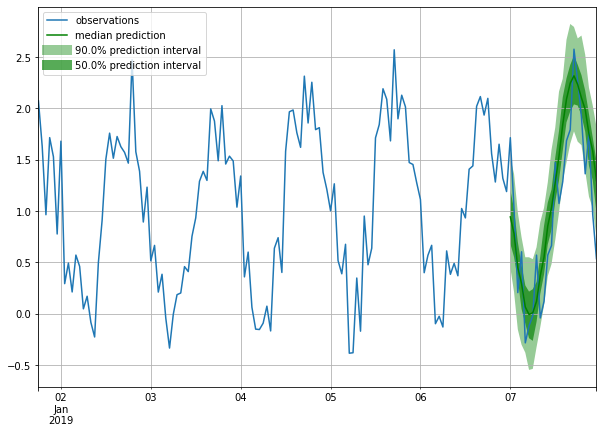

In [93]:
plot_prob_forecasts(tss[0], forecasts[0])